# Project Management Course - Applied AI Solutions Development

The dataset we will be using is from the Government of Canada website https://open.canada.ca/data/en/dataset/0e1e57aa-e664-41b5-a69f-d814d4407d62.  The dataset is 
an indexed time series of the Toronto Stock Exchange closing prices.  We will be building 3 forecasting models for comparison.  A SARIMAX (Seasonal 
AutoRegressive Moving Averages) model, Facebook's Neural Prophet, and a custom LSTM model.

Importing necessary libraries

In [111]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import os

# Data Exploration

In [112]:
# Importing our dataset to take a first look
df = pd.read_csv("10100125.csv")
df.head()

,REF_DATE,GEO,DGUID,Toronto Stock Exchange Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1956-01,Canada,2016A000011124,Standard and Poor's/Toronto Stock Exchange Com...,"Index, 2000=1000",176,units,0,v122620,1.3,525.63,NaN,NaN,NaN,2
1,1956-01,Canada,2016A000011124,"Toronto Stock Exchange, oil and gas, closing q...","Index, 2000=1000",176,units,0,v122621,1.4,485.02,NaN,NaN,t,2
2,1956-01,Canada,2016A000011124,"Toronto Stock Exchange, metals and minerals, c...","Index, 2000=1000",176,units,0,v122622,1.5,729.73,NaN,NaN,t,2
3,1956-01,Canada,2016A000011124,"Toronto Stock Exchange, utilities, closing quo...","Index, 2000=1000",176,units,0,v122623,1.6,914.11,NaN,NaN,t,2
4,1956-01,Canada,2016A000011124,"Toronto Stock Exchange, paper and forest produ...","Index, 2000=1000",176,units,0,v122624,1.7,1013.23,NaN,NaN,t,2


In [3]:
# The dataset appears to be a monthly record of the TSE's closing price, indexed to the year 2000 (1000 point index).  The TSE is then split into different industry composites,
# for example mining vs forest products.  The UOM_ID, scalar_factor, and secalar_id should be consistent throughout the dataset, this will need to be verified.  

df['REF_DATE'].min(), df['REF_DATE'].max()

# Our dataset appears to cover from Jan 1956 until Dec 2021.

('1956-01', '2021-12')

In [8]:
# Checking the GEO feature to confirm all values say Canada, and this column is only provided for convenience when combining datasets
df['GEO'].value_counts()

# Confirmed, this feature will need to be dropped

Canada    11134
Name: GEO, dtype: int64

In [10]:
# This code, after some research, is a geographic identifier.  It should be consistent and can be dropped
df['DGUID'].value_counts()

2016A000011124    11134
Name: DGUID, dtype: int64

In [11]:
# Next we come to the description of the index provided.  We are only interested in the composite of the entire market.  The industry indexes are likely to have changed
# over the years.

df['Toronto Stock Exchange Statistics'].value_counts()

# As we can see the opening and closing prices weren't tracked for the first 150 time periods.

Standard and Poor's/Toronto Stock Exchange Composite Index, close                          792
Toronto Stock Exchange, stock dividend yields (composite), closing quotations              729
Toronto Stock Exchange, price earnings ratio, closing quotations                           729
Toronto Stock Exchange, oil and gas, closing quotations                                    570
Toronto Stock Exchange, metals and minerals, closing quotations                            570
Toronto Stock Exchange, utilities, closing quotations                                      570
Toronto Stock Exchange, paper and forest products, closing quotations                      570
Toronto Stock Exchange, merchandising, closing quotations                                  570
Toronto Stock Exchange, financial services, closing quotations                             570
Toronto Stock Exchange, gold and silver, closing quotations                                570
Standard and Poor's/Toronto Stock Exchange Composi

In [19]:
# We need to confirm that our intended subset spans the entire period we're looking for, and there's no name change
closing_subset = df.loc[df['Toronto Stock Exchange Statistics'] == 'Standard and Poor\'s/Toronto Stock Exchange Composite Index, close']

print(closing_subset.head())
print(closing_subset.tail())

# Here we confirm that our intended category spans the entirety of Jan 1956 to Dec 2021.

   REF_DATE     GEO           DGUID  \
0   1956-01  Canada  2016A000011124   
10  1956-02  Canada  2016A000011124   
20  1956-03  Canada  2016A000011124   
30  1956-04  Canada  2016A000011124   
40  1956-05  Canada  2016A000011124   

                    Toronto Stock Exchange Statistics               UOM  \
0   Standard and Poor's/Toronto Stock Exchange Com...  Index, 2000=1000   
10  Standard and Poor's/Toronto Stock Exchange Com...  Index, 2000=1000   
20  Standard and Poor's/Toronto Stock Exchange Com...  Index, 2000=1000   
30  Standard and Poor's/Toronto Stock Exchange Com...  Index, 2000=1000   
40  Standard and Poor's/Toronto Stock Exchange Com...  Index, 2000=1000   

    UOM_ID SCALAR_FACTOR  SCALAR_ID   VECTOR  COORDINATE   VALUE STATUS  \
0      176        units           0  v122620         1.3  525.63    NaN   
10     176        units           0  v122620         1.3  545.15    NaN   
20     176        units           0  v122620         1.3  588.91    NaN   
30     176    

In [21]:
# Here we confirm that UOM is standardized throughout our dataset
closing_subset['UOM'].value_counts()

Index, 2000=1000    792
Name: UOM, dtype: int64

In [22]:
# Unnecessary feature
closing_subset['UOM_ID'].value_counts()

176    792
Name: UOM_ID, dtype: int64

In [24]:
# Unnecessary feature
closing_subset['VECTOR'].value_counts()

v122620    792
Name: VECTOR, dtype: int64

In [25]:
# We can now safely assume that all other values are standardized and unnecessary for our model, we only need a subset of the closing TSE values and the time period

# Data Cleaning

In [113]:
# Here we create a subset to extract only data on the TSE records
df = df.loc[df['Toronto Stock Exchange Statistics'] == 'Standard and Poor\'s/Toronto Stock Exchange Composite Index, close']

In [114]:
# Then we can extract only the data and value columns
df = df[['REF_DATE', 'VALUE']].reset_index(drop=True)

# Data Exploration and Decomposition

In [279]:
# It's time to do some data exploration.  In order to prepare our data, we need to set the index in a datatime format, and have one column of values
Y = df['VALUE']
date = df['REF_DATE']
date = np.array(date,dtype=np.datetime64)
series = pd.DataFrame(Y)
series = Series.set_index(date, drop=True)
series.tail(7)

,VALUE
2021-06-01,20165.58
2021-07-01,20287.80
2021-08-01,20582.94
2021-09-01,20070.30
2021-10-01,21037.10
2021-11-01,20660.00
2021-12-01,21223.00


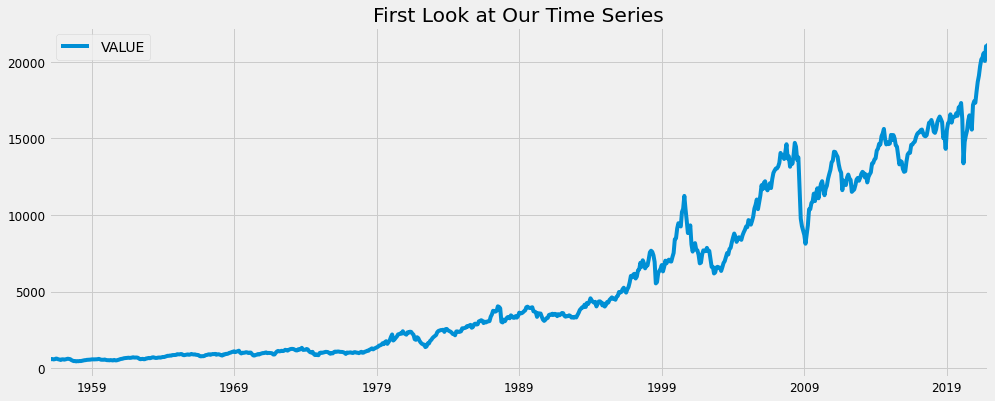

In [20]:
# Here we plot our data to get a first look
series.plot(figsize=(15, 6))
plt.title('First Look at Our Time Series')
plt.show()

Time series data can exhibit a variety of patterns, and it is often helpful to split a time series into several components, each representing an underlying pattern category.
If we assume an additive decomposition, then we can write yt=St+Tt+Rt,where yt is the data, St is the seasonal component, Tt is the trend-cycle component, and Rt is 
the remainder component, all at period t. Alternatively, a multiplicative decomposition would be written as yt=St×Tt×Rt.
The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary 
with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level
of the time series, then a multiplicative decomposition is more appropriate. 

The first graph represents the raw data of our model.  The 3 subsequent graphs represent the decomposed components of our raw data, that can be added together
to reconstruct the data shown in the top panel  The first graph is the raw data, the 2nd is the trend, 3rd is the seasonality component, and the 4th represents the 
residuals.

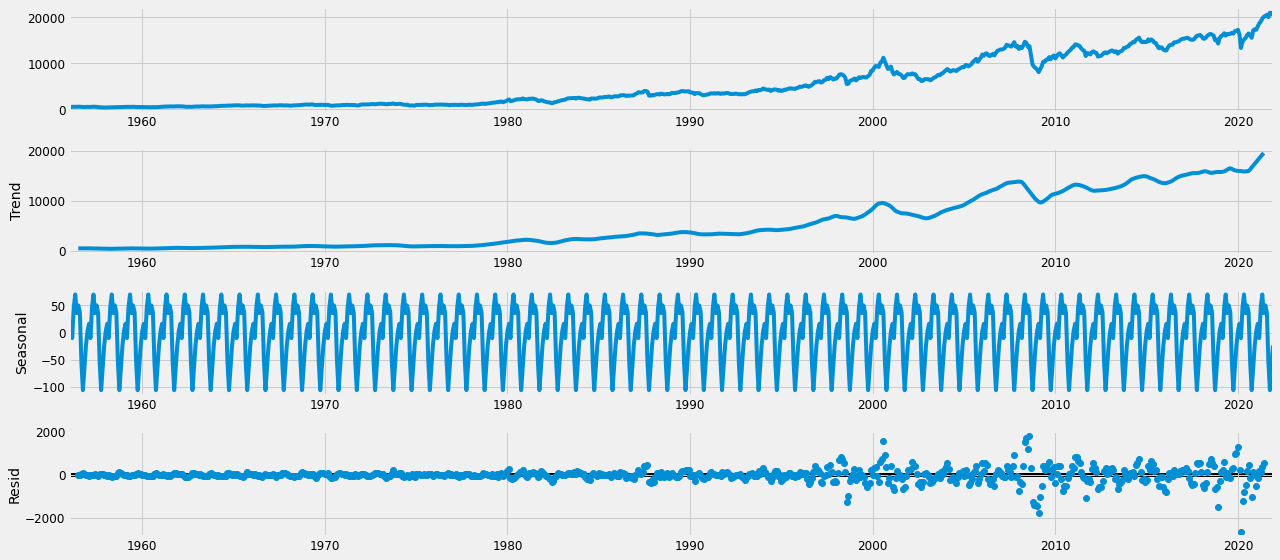

In [21]:
# First we will check an additive decomposition with a period of 12, or 1 year

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(series, model='additive', period=12)
fig = decomposition.plot()
plt.show()

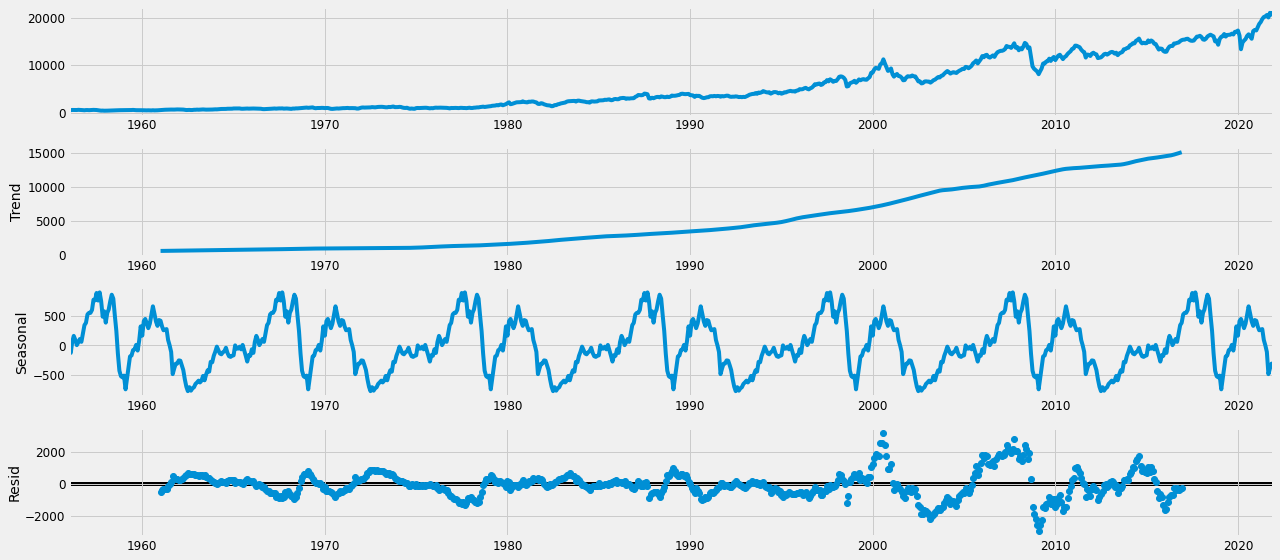

In [22]:
# Here we check seasonality over 120 periods, or 10 years
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(series, model='additive', period=120)
fig = decomposition.plot()
plt.show()

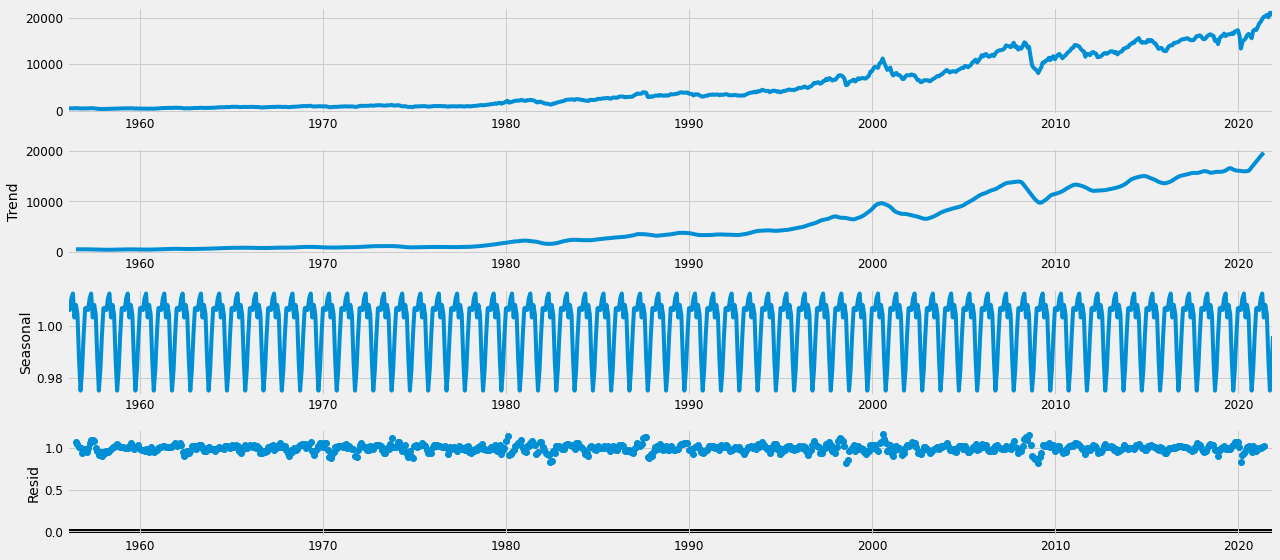

In [23]:
# Multiplicative model over 12 periods, or 1 year
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(series, model='multiplicative', period=12)
fig = decomposition.plot()
plt.show()

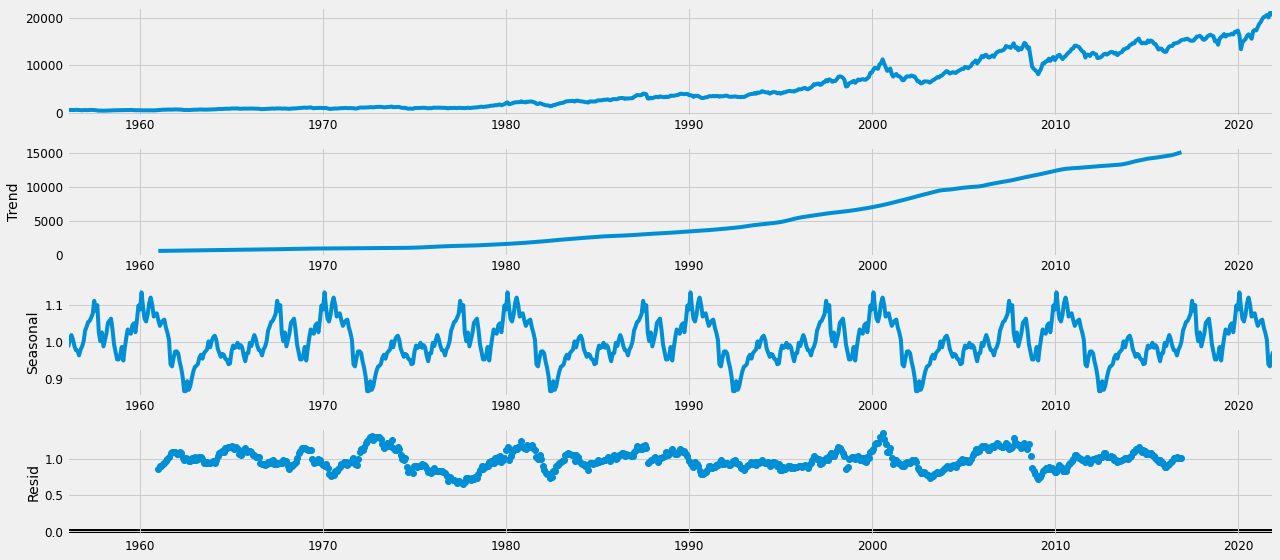

In [24]:
#Multiplicative decomposition over a period of 120 periods, or 10 years
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(series, model='multiplicative', period=120)
fig = decomposition.plot()
plt.show()

As we can see, a multiplicative model results is lower residuals.  Residuals are useful in checking whether a model has adequately captured the information in the data.
In addition, residuals should be uncorrelated, as we can see in our 120 period multiplicative model, the residuals appear to follow the trend of the seasonality chart,
meaning it has not captured the data well.

This will be useful information for hyperparameter tuning our models.

Non-linear models can be difficult for models.  We can see if transforming our data would be beneficial.

### Log Transform of our Signal

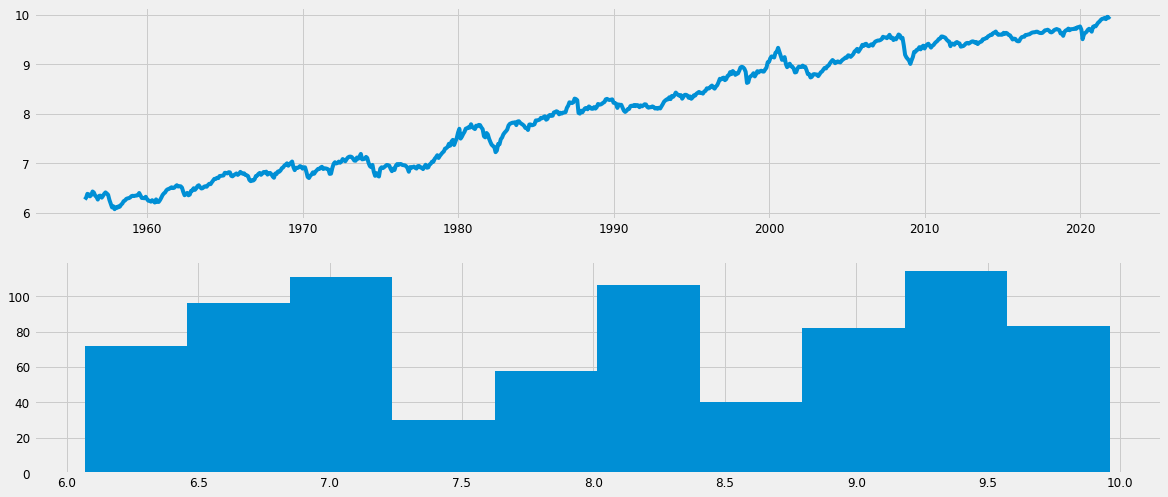

In [25]:
from matplotlib import pyplot
from math import exp
from numpy import log

y = log(series)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(y)
# histogram
pyplot.subplot(212)
pyplot.hist(y)
pyplot.show()

Log transforming our signal turns the growth of our trendline from an exponential growth line to a linear growth line.  This will help our model performance

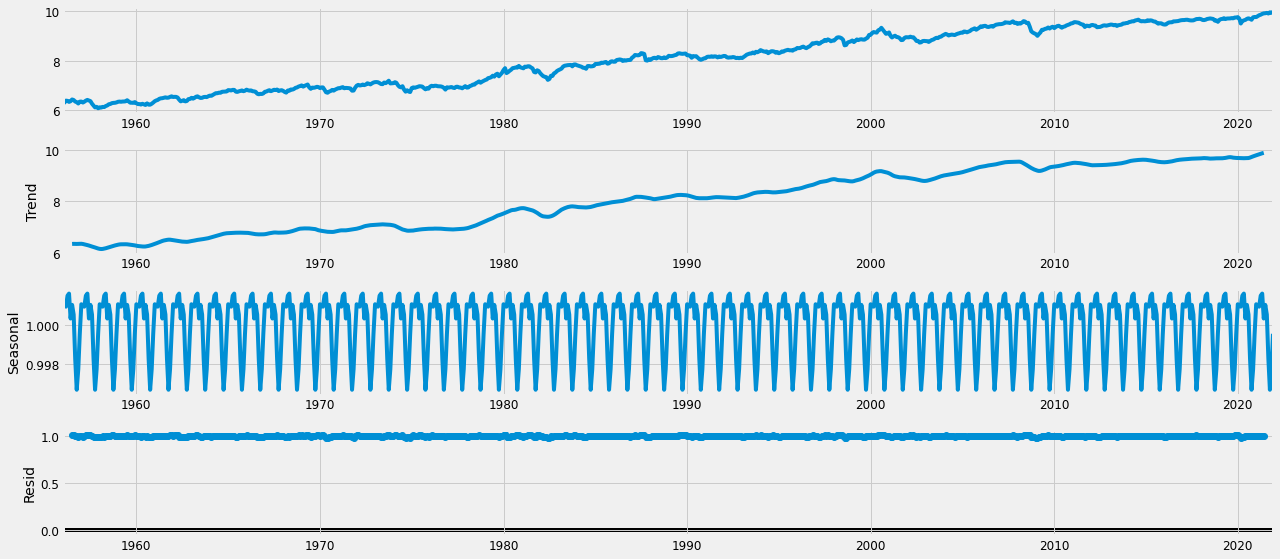

In [26]:
# Now if we do a 12 month decomposition the residuals appear as white noise (or random)
# Having our mean and variance not changing over time is called stationarity, and is ideal for model creaetion

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative', period=12)
fig = decomposition.plot()
plt.show()

# Train/Test Split

In order to evaluate our models we need a test sample.  We will be removing the last 6 months of data from our models as a test sample.
Once we've built each of the models we will then calculate the MSE between the predictions and real values, and deem the one with the 
lowest MSE as our best model

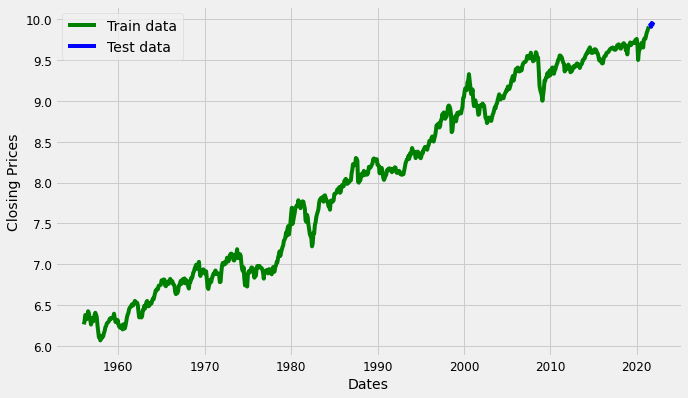

In [116]:
y_train = y.iloc[:-6]
y_test = y.iloc[-6:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(y_train, 'green', label='Train data')
plt.plot(y_test, 'blue', label='Test data')
plt.legend()

# Forecast Models

### SARIMAX

A seasonal ARIMA model (or SARIMAX model) is formed by including additional seasonal terms in an ARIMA model. An ARIMA model is made up of 3 parts:

p = order of the autoregressive part;
d = Degree of first differencing involved;
q = order of the moving average part.
A SARIMAX model has the basic ARIMA model, plus another component modeling the seasonal component:

P = seasonal order of the autoregressive part;
D = degress of the first differencing involved;
Q = order of the moving average;
P = period of seasonality

The goal of an SARIMAX model is to grid search hyperparameters, by checking the AIC score (Akaike’s Information Criterion). 
The lower the AIC score the better, where residuals should also appear as white noise without a pattern.

In [117]:
# Installing necessary libraries

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

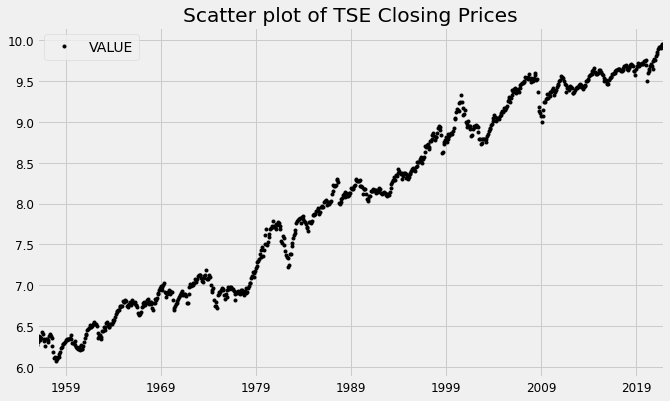

In [118]:
# Copying the log transformed data and plotting the graph to get a look at the data we'll be using for SARIMAX

df_close = y
df_close.plot(style='k.')
plt.title('Scatter plot of TSE Closing Prices')
plt.show()

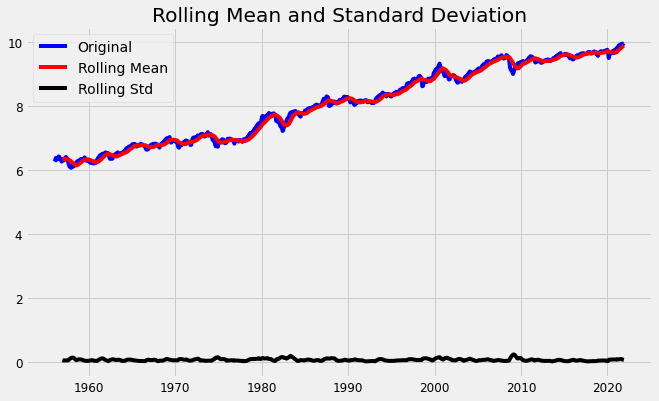

Results of dickey fuller test
Test Statistics                 -0.398698
p-value                          0.910316
No. of lags used                 1.000000
Number of observations used    790.000000
critical value (1%)             -3.438655
critical value (5%)             -2.865205
critical value (10%)            -2.568722
dtype: float64


In [34]:
# Test for staionarity
# Stationarity is when the mean and variance do not change over time, which is ideal for model creation.  The test for this is a
# Dickey Fuller test, a kind of A/B test, that tests the probability of stationarity

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

The Dicky Fuller test can be read as the lower the number the better.  The lower the number the more we can reject the hypothesis
that there is no stationarity

<Figure size 720x432 with 0 Axes>

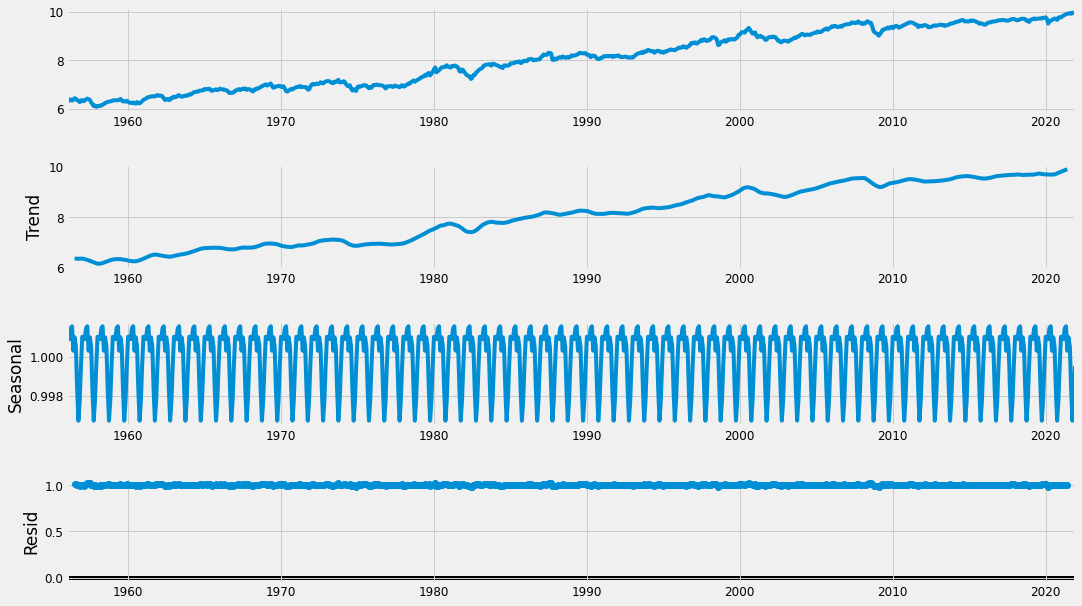

In [35]:
# A seasonal decomposition analysis based on 12 months, multiplicative model, on the log of our data

result = seasonal_decompose(df_close, model='multiplicative', period=12)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


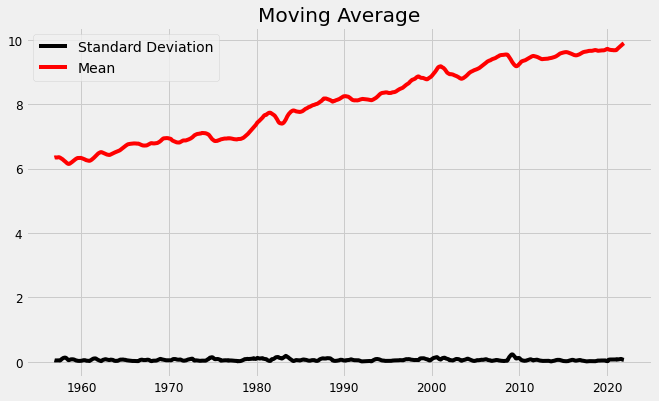

In [36]:
# Here we are checking the standard deviation and the mean of the moving average.  Looking for insights into our data

rcParams['figure.figsize'] = 10, 6
df_log = df_close
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [39]:
# Autoarima is a great way to get initial hyperparameters.  It cannot be taken on it's own though, and must be evaluated to be accepted
# Here we are using autoARIMA to determine the best model parameters without seasonality

model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5524.680, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2670.759, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2669.692, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2672.019, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1402.915, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-2671.614, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2670.932, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2462.610, Time=0.01 s

<b>AutoARIMA has detected a great contender for our model, with an AIC score of -2672.019 </b>

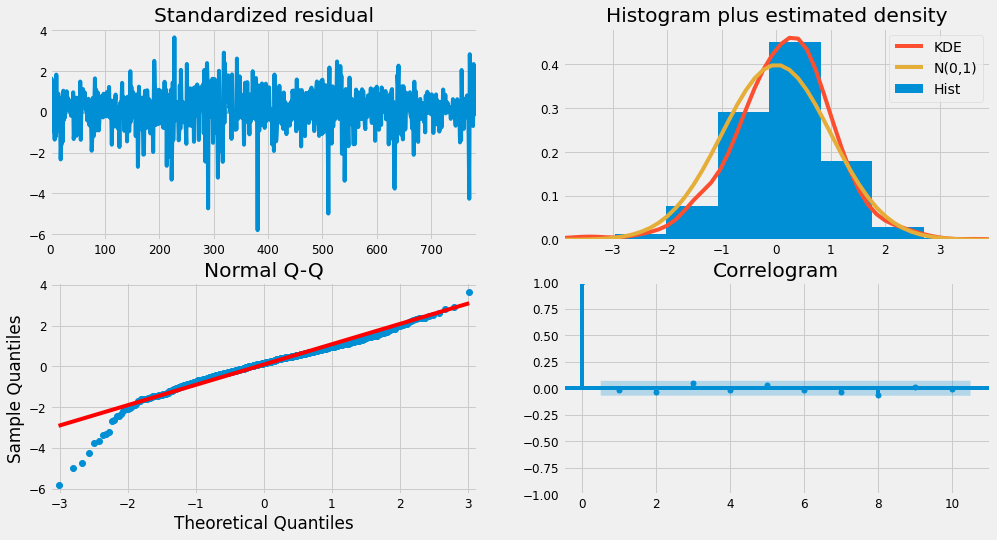

In [40]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [41]:
# Now that we have the ideal parameters for our model without seasonality, we will be adding the seasonal component using SARIMAX
# and itertools to iterate over multiple possibilities

d = p = q = range(0,3)
pdq = (1,0,1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format((1,0,1), seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format((1,0,1), seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format((1,0,1), seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format((1,0,1), seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (1, 0, 1) x (0, 0, 1, 12)
SARIMAX: (1, 0, 1) x (0, 0, 2, 12)
SARIMAX: (1, 0, 1) x (0, 1, 0, 12)
SARIMAX: (1, 0, 1) x (0, 1, 1, 12)


In [51]:
# Here we are doing a grid search for the best seasonal components

from statsmodels.tsa.statespace.sarimax import SARIMAX

for param_seasonal in seasonal_pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(y_train,
                                        order=(1, 0, 1),
                                        seasonal_order=param_seasonal)
        results = mod.fit()
        print('ARIMA{}x{} - AIC:{}'.format((1, 0, 1), param_seasonal, results.aic))
    except:
        continue

ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:-2670.758633608036
ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:-2669.330044158579
ARIMA(1, 0, 1)x(0, 0, 2, 12) - AIC:-2667.4744995861915
ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:-2114.395933648634
ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:-2608.3898899442675
ARIMA(1, 0, 1)x(0, 1, 2, 12) - AIC:-2608.402407275711
ARIMA(1, 0, 1)x(0, 2, 0, 12) - AIC:-1251.1022402684823
ARIMA(1, 0, 1)x(0, 2, 1, 12) - AIC:-2022.5490500254732
ARIMA(1, 0, 1)x(0, 2, 2, 12) - AIC:-2459.699780784974
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:-2668.920934489898
ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:-2674.7672757320315
ARIMA(1, 0, 1)x(1, 0, 2, 12) - AIC:-2669.372893326282
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:-2343.3938665813052
ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:-2608.373201235565
ARIMA(1, 0, 1)x(1, 1, 2, 12) - AIC:-2608.652775759231
ARIMA(1, 0, 1)x(1, 2, 0, 12) - AIC:-1688.0873960145432
ARIMA(1, 0, 1)x(1, 2, 1, 12) - AIC:-2239.5785015233537
ARIMA(1, 0, 1)x(1, 2, 2, 12) - AIC:-2457.096992530166
ARIMA(1, 0, 1)x(2, 0

<b>The model we've found with the lowest AIC score is a SARIMAX model of (1, 0, 1)x(2, 0, 1, 12)12, with an AIC score of -2669.90449750553 </b>

In [52]:
model = SARIMAX(y_train, order=(1, 0, 1),seasonal_order=(1,0,1,12))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              VALUE   No. Observations:                  786
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                1342.384
Date:                            Sun, 27 Feb 2022   AIC                          -2674.767
Time:                                    10:29:07   BIC                          -2651.432
Sample:                                01-01-1956   HQIC                         -2665.796
                                     - 06-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.001    725.715      0.000       0.997       1.002
ma.L1          0.1167      0.013   

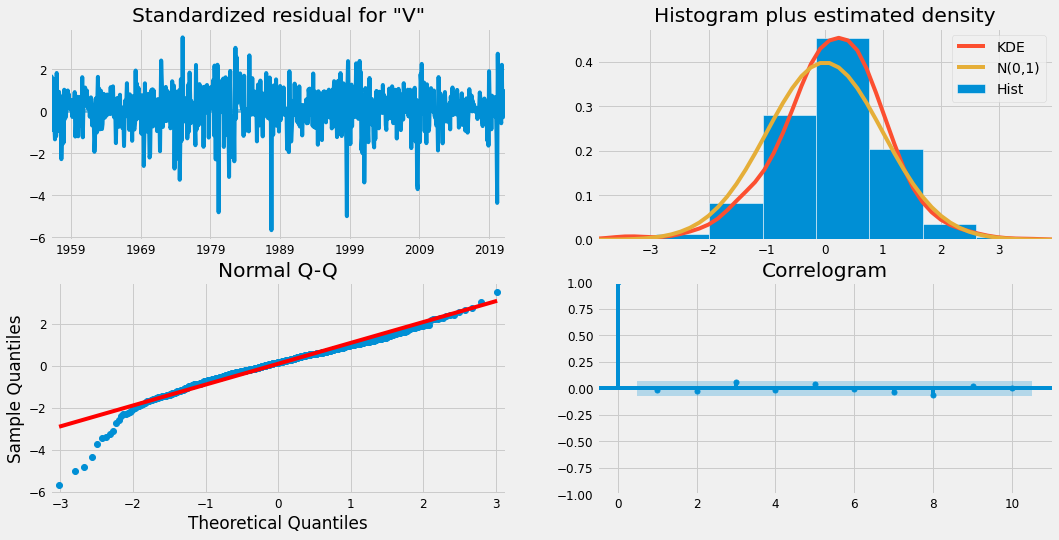

In [53]:
fitted.plot_diagnostics(figsize=(16, 8))
plt.show()

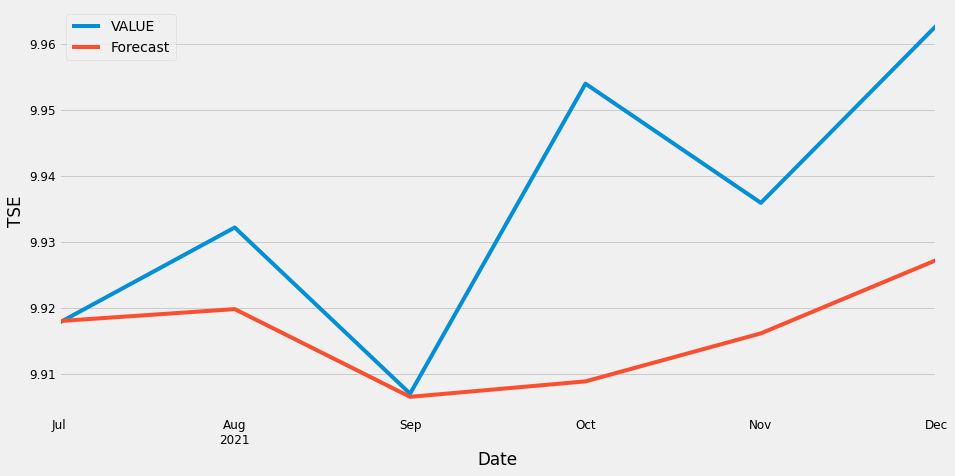

In [54]:
#  Now all that's left to do is predict with our model

pred_uc = results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = y_test.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('TSE')
plt.legend()
plt.show()

In [55]:
# Next we need to reverse our log so we use the exp function from numpy.  In addition, we need to extract the predicted values from the get_forecast
# wrapper

pred_ci['lower VALUE'] = np.exp(pred_ci['lower VALUE'])
pred_ci['upper VALUE'] = np.exp(pred_ci['upper VALUE'])
pred_ci['mid VALUE'] = (pred_ci['lower VALUE'] + pred_ci["upper VALUE"]) /2

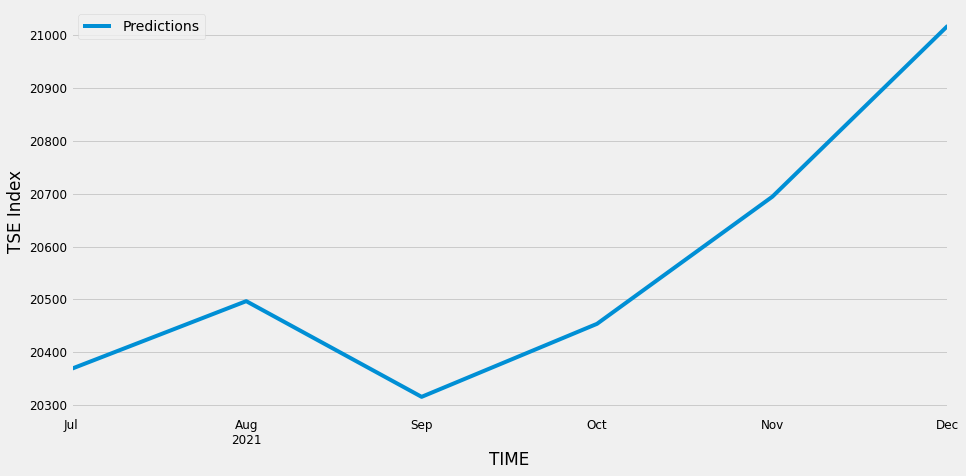

In [58]:
# Now we can see the real values vs the predicted value in dollar terms

SARIMAX = pred_ci['mid VALUE']
  
ax = SARIMAX.plot(label='Predictions', figsize=(14, 7))
ax.plot(ax=ax, label='Forecast')
ax.set_xlabel('TIME')
ax.set_ylabel('TSE Index')
plt.legend()
plt.show()

### Neural Prophet

Neural Prophet is facebook's improvement upon their old forecasting package called Prophet.  The aim is to combine traditional forecasting techniques with neural network
models, in order to provide more readability than neural networks.

In [240]:
from neuralprophet import NeuralProphet
import pandas as pd

In [280]:
# For Neural Prophet we only need 2 columns, time in a column called ds and Y for the values
neurodata = df[['REF_DATE', 'VALUE']]
neurodata.rename(columns = {'REF_DATE':'ds', 'VALUE':'y'}, inplace=True)
print(neurodata.head())
print(neurodata.tail(7))

        ds       y
0  1956-01  525.63
1  1956-02  545.15
2  1956-03  588.91
3  1956-04  583.61
4  1956-05  560.09
          ds         y
785  2021-06  20165.58
786  2021-07  20287.80
787  2021-08  20582.94
788  2021-09  20070.30
789  2021-10  21037.10
790  2021-11  20660.00
791  2021-12  21223.00


In [242]:
# Applying our log transform
neurodata['y'] = np.log(neurodata['y'])

In [243]:
#  We will need to do another train/test split on the structure of data that neuro prophet requires.
neuro_test = neurodata.iloc[-6:]
neuro_train = neurodata.iloc[:-6]

In [244]:
neuro_train.tail()

,ds,y
781,2021-02,9.801469
782,2021-03,9.836315
783,2021-04,9.857880
784,2021-05,9.889946
785,2021-06,9.911732


In [316]:
''' The model has been built to be easy to deploy with only a couple lines of code.  Hyperparameter tuning is done with variables within
the model, and takes some getting used to.  '''

m = NeuralProphet(seasonality_mode='multiplicative',  
                  num_hidden_layers=1,
                  changepoints_range=1)
metrics = m.fit(neuro_train,
                freq="M")
forecast = m.predict(neuro_train,
                    decompose=True)

INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 192


  0%|          | 0/245 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.40E-02, min: 4.32E+00


  0%|          | 0/245 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.40E-02, min: 2.01E+00


  0%|          | 0/245 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.04E-02, min: 4.32E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.28E-02
Epoch[192/192]: 100%|██████████| 192/192 [00:09<00:00, 20.05it/s, SmoothL1Loss=0.000625, MAE=0.0986, RMSE=0.124, RegLoss=0]


In [317]:
# We've built our model, now we need to forecast a period of 6 months in the future to see how it performs
future = m.make_future_dataframe(neuro_train, periods=6)
forecast = m.predict(future)

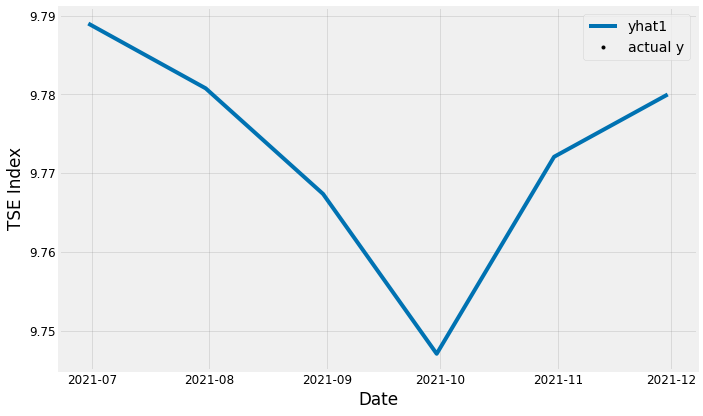

In [318]:
# First look at neuroprophet's predictions
forecasts_plot = m.plot(forecast,
                        xlabel='Date',
                        ylabel='TSE Index',
                        figsize=(10, 6))

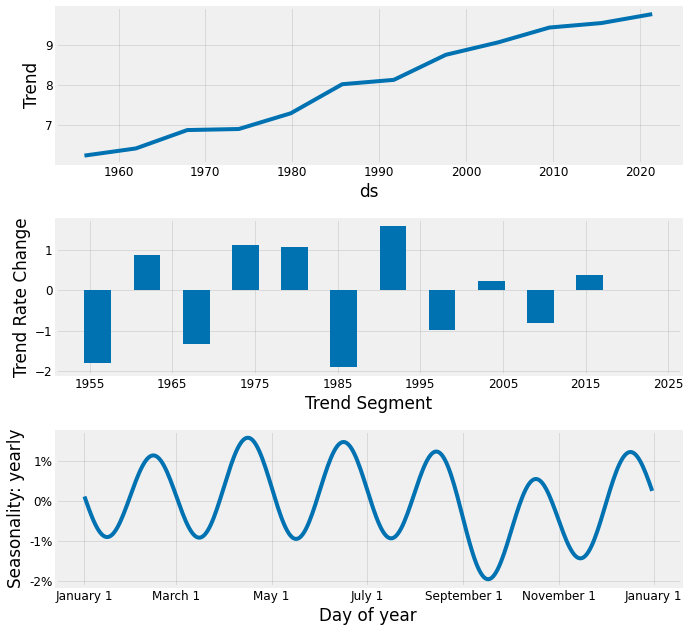

In [319]:
fig_param = m.plot_parameters()

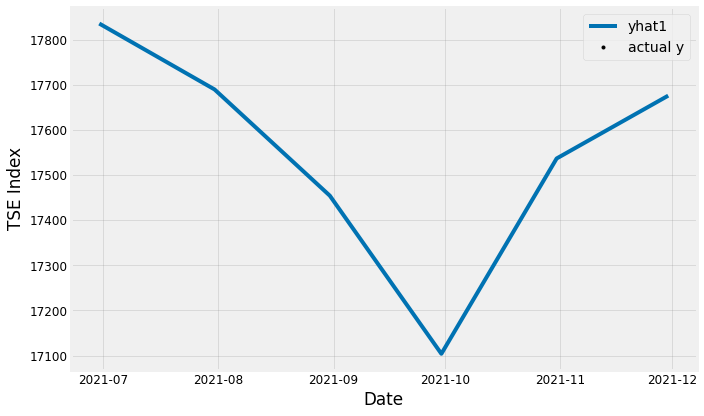

In [320]:
# This is our current signal, but our signal has been transformed.  We will need to reverse log transform our data back to get valid numbers
# Now we need to reverse our log of the data
forecast['yhat1'] = np.exp(forecast['yhat1'])
forecasts_plot = m.plot(forecast,
                        xlabel='Date',
                        ylabel='TSE Index',
                        figsize=(10, 6))

In [321]:
# Things aren't looking good for neuroprophet's accuracy based on what we know about the test set.  Perhaps we are missing some key
# hyperparameter tuning, but it appears to have made a poor prediction

# Benchmarking The Models

First we need to combine the real values with all the predictions

In [270]:
from sklearn.metrics import mean_squared_error

In [322]:
# Step 1 is to reverse the logarithmic transformation of our y_test
actual = np.exp(y_test)

In [323]:
# Extracting the neural prophet's forecast
neural_forecast = forecast['yhat1'].iloc[-6:]

In [324]:
# SARIMAX root mean squared error
MSE_sarimax = np.sqrt(mean_squared_error(actual, SARIMAX))
print(MSE_sarimax)

276.1907199830971


In [325]:
# Neural Prophet root mean squared error
MSE_neural = np.sqrt(mean_squared_error(actual, neural_forecast))
print(MSE_neural)

3136.3471446400727


In [333]:
# Now we're creating a dataframe of Actual, Sarimax, and neural prophet results
benchmark = pd.DataFrame([MSE_sarimax, MSE_neural], index=['SARIMAX', 'Neural Prophet'], columns=['Root Mean Squared Error'])
benchmark

,Root Mean Squared Error
SARIMAX,276.190720
Neural Prophet,3136.347145


In [334]:
# For the two models provided, given our test SARIMAX is the clear winner